***KNOWN***

// general info

- Binary Classification Task
- features = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
- target = ['Exited']
- no external test set: 3:1:1 - training:valid:test - 60%:20%:20%

// feature types

- Categorical Features: ['Surname', 'Geography', 'Gender']
- Numerical Features: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
- Target is Numerical

// misc observations

- Tenure column has 9091 / 10000 entries (-909) (1.1% missing)
- Surname column contains entries with special characters: data['Surname'][9] = 'H?'
- no duplicate CustomerId, 10000 different customers
- 'IsActiveMemeber' not mutually exclusive with 'Exited'

// class balance

- 79.63% of customers have exited ('Exited' == 1)
- 20.37% of customers have not exited ('Exited' == 0)

***UNKNOWN***
- model type? DecisionTreeClassifier, RandomForestClassifier, LogisticRegression
- hyperparameters?
- class balancing methods?
- threshold tuning?

***OBJECTIVES***
- F1 score: 0.59 against test set
- Plot ROC and measure AUC-ROC
- methods of balance to try: upsampling & class_weight='balanced'

In [125]:
import pandas as pd

data = pd.read_csv('Churn.csv')

#print(data.dtypes)
#data.info(verbose=True)
#display(data.head(10))
#print(data['Surname'][9])
#print(data.isna().sum())
#print(data['CustomerId'].duplicated().sum())
#print(data['Surname'].value_counts())
#print(data[data['Surname'] == 'Smith'])
#print(data.duplicated(subset='CustomerId').value_counts())
#print(data[data['Tenure'].isna()])
#print(data[(data['Tenure'] > 0) & (data['Tenure'] < 1)])
#print(data[(data['Tenure'] < 1)])
#print(data['Geography'].value_counts())

data['Tenure_Missing'] = data['Tenure'].isnull().astype(int)
data['Tenure'] = data['Tenure'].fillna(0)
#print(data[data['Tenure_Missing'] == 1])
#print(data.info(verbose=True))

#print(data['Exited'].value_counts(normalize=True))

***data analysis & cleaning, adding surface-level observations to known & unknown***

**We've done away with the missing values within the 'Tenure' column, replacing them with 0. Seeing as though 'Tenure' is measured in years, and only whole numbers, if there exists a customer with 11 months of loan history, are they rounded up to 1.0? or do they remain at 0.0? Or could the missing values have different implications on a per observation basis? Human error, new customer, bank system glitch, or has no active loan?**

**In any case, I've decided to create a new column that saves the instances of 'Tenure' == NaN, as 'Tenure_Missing'**

**Class balance is 79.63% negative, 20.37% positive. We NEED to consider this when training our model later, as predicting positive for every observation would yield a ~80% accuracy rating**

In [126]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# since our categorical entries are nominal, we will use OHE to prepare them
data_ohe = pd.get_dummies(data, drop_first=True)

# separate features from target
features = data_ohe.drop('Exited', axis=1)
target = data_ohe['Exited']

# 60% train set, 40% temporary set
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=.4, random_state=12345)

# 20% valid set, 20% test set
features_valid , features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=.5, random_state=12345)

# specify numeric features
numeric = ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

# tune scaler to training data features
scaler = StandardScaler()
scaler.fit(features_train[numeric])

# apply scaling to numeric columns in our feature sets
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

#print(features_train.head())
#print(features_valid.head())
#print(features_test.head())

**Data preprocessing is completed, next steps are training a model without considerations to class imbalance**

In [156]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# training model on vanilla data, no upsampling, predicting target_valid using features_valid
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

# custom function for extracting multiple score metrics
def get_scores(target, predictions):
    accuracy = accuracy_score(target, predictions)
    recall = recall_score(target, predictions)
    precision = precision_score(target, predictions)
    f1 = f1_score(target, predictions)
    return {'Accuracy': f'{accuracy:.3f}',
            'Recall': f'{recall:.3f}',
            'Precision': f'{precision:.3f}',
            'F1': f'{f1:.3f}'}

# capturing naive baseline accuracy of our test_valid set
most_frequent = target_valid.mode()[0]
baseline_accuracy = (target_valid == most_frequent).sum() / len(target_valid)

print(get_scores(target_valid, predicted_valid))
print(f'\nConfusion Matrix:\n', confusion_matrix(target_valid, predicted_valid))
print()
print('Naive baseline accuracy of the validation set: ', baseline_accuracy)

{'Accuracy': '0.831', 'Recall': '0.498', 'Precision': '0.619', 'F1': '0.552'}

Confusion Matrix:
 [[1454  128]
 [ 210  208]]

Naive baseline accuracy of the validation set:  0.791


**After calcuating naive baseline accuracy, we can see that the accuracy of our model (.831) is barely performing better than just predicting the most common observation (.791). Our recall of .49 tells us that our model, without upsampling to balance classes, is predicting alot of false negatives. While our precision score of .61 tells us that our model is having an easier time missing false positives, again because of the class weight imbalance. These two metrics give us an F1 score of .55, which again lets us know that our model is hardly performing better than guessing**

***Model evaluation without class balancing is completed, scoring metrics are pulled, next step is to use two different weight balancing methods to see which one yields us the best model for our goal***

In [128]:
from sklearn.utils import shuffle

# upsample function creation
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

# creating new, uspampled training sets, using a repeat value of 4 to get our class weight close to 50/50
features_upsampled , target_upsampled = upsample(features_train, target_train, 4)

**Upsampling completed, training model with new balanced training sets, displaying metric scores. Then applying hyperparameter (class_weight='balanced') to compare results**

In [129]:
# preserved score metrics from model trained on imbalanced data
print(f'Imbalanced Decision Tree: ', {'Accuracy': '0.831', 'Recall': '0.498', 'Precision': '0.619', 'F1': '0.552'})

# training model on upsampled data, extracting score metrics
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print(f'Upsampled Decision Tree: ', get_scores(target_valid, predicted_valid))

# training model on vanilla data, utilizing class weight balancing hyperparameter
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(f'Weighted Decision Tree: ', get_scores(target_valid, predicted_valid))

Imbalanced Decision Tree:  {'Accuracy': '0.831', 'Recall': '0.498', 'Precision': '0.619', 'F1': '0.552'}
Upsampled Decision Tree:  {'Accuracy': '0.809', 'Recall': '0.572', 'Precision': '0.541', 'F1': '0.556'}
Weighted Decision Tree:  {'Accuracy': '0.810', 'Recall': '0.574', 'Precision': '0.544', 'F1': '0.559'}


**After training our model in 3 different "environments" (imbalanced, upsampled, weighted), we can see that utilizing the class weight balancing hyperparameter (class_weight='balanced') yields us the best results for this specific task**

***Next step is to iterate through differing models and parameters to find the best one for our task, with a desired F1 score of at least .59***

In [ ]:
# DECISION TREE TRAINING WITH SCORES

best_model = None
best_result = 0

# loop to iterate through tree depth, saving best model and score
# hashing out model training loops to save memory space

#for depth in range(1, 31):
    #model = DecisionTreeClassifier(random_state=12345, class_weight='balanced', max_depth=depth)
    #model.fit(features_train, target_train)
    #predicted_valid = model.predict(features_valid)
    #score = f1_score(target_valid, predicted_valid)
    #if score > best_result:
        #best_model = model
        #best_result = score

#print('Best Model: ', best_model)
#print('F1 score of best model: ', best_result)

# resulting model from depth training
model = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(get_scores(target_valid, predicted_valid))
print('\nConfusion Matrix:\n', confusion_matrix(target_valid, predicted_valid))

# i looped through 2 more hyperparameters, 

{'Accuracy': '0.809', 'Recall': '0.677', 'Precision': '0.534', 'F1': '0.597'}

Confusion Matrix:
 [[1335  247]
 [ 135  283]]


**We've crossed the F1 score threshold with this model (0.597), and have made remarkable improvements compared to our model trained on imbalanced data. The confusion matrix also shows us that our model is catching more True Negatives & True Positives (1335 & 283), than it is catching False Negatives and False Positives (135 & 247)**

***I will continue to train other models to see if we can get our scores any higher***

In [131]:
# RANDOM FOREST TRAINING WITH SCORES

from sklearn.ensemble import RandomForestClassifier

#best_model = None
#best_result = 0

# loop to iterate through forest depth and estimators count
# hashing out model training for better notebook performance

#for est in range(40, 101, 10):
    #for depth in range(1, 31):
        #model = RandomForestClassifier(random_state=12345, class_weight='balanced',
                                       #n_estimators=est, max_depth=depth)
        #model.fit(features_train, target_train)
        #predicted_valid = model.predict(features_valid)
        #score = f1_score(target_valid, predicted_valid)
        #if score > best_result:
            #best_model = model
            #best_result = score

#print(best_model, best_result)

# resulting model from depth and estimators training
model = RandomForestClassifier(class_weight='balanced', max_depth=40, n_estimators=90, random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(get_scores(target_valid, predicted_valid))
print('\nConfusion Matrix:\n', confusion_matrix(target_valid, predicted_valid))

{'Accuracy': '0.835', 'Recall': '0.548', 'Precision': '0.619', 'F1': '0.581'}

Confusion Matrix:
 [[1441  141]
 [ 189  229]]


**Our Random Forest Classification model scored slightly higher in recall, but took a noticeable hit to precision and F1 score. We will stick to the Decision Tree model for the time being, but Logistic Regression still has a chance to shine hopefully!**

In [132]:
# LOGISTIC REGRESSION TRAINING WITH SCORES

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(get_scores(target_valid, predicted_valid))
print('\nConfusion Matrix:\n', confusion_matrix(target_valid, predicted_valid))

{'Accuracy': '0.710', 'Recall': '0.617', 'Precision': '0.380', 'F1': '0.470'}

Confusion Matrix:
 [[1161  421]
 [ 160  258]]


**Our Logistic Regression model scored significantly worse than even the Random Forest model, with a precision score of (0.380) and an F1 score of (0.470). All models were trained with the class weight hyperparameter, and made predictions on our validation set. The next step is to assess our Decision Tree model's performance on 'new data', our test set.**

In [133]:
print(f'Decision Tree Classifier: ', {'Accuracy': '0.809', 'Recall': '0.677', 'Precision': '0.534', 'F1': '0.597'})
print(f'Random Forest Classifier: ', {'Accuracy': '0.789', 'Recall': '0.682', 'Precision': '0.497', 'F1': '0.575'})
print(f'Logistic Regression: ', {'Accuracy': '0.710', 'Recall': '0.617', 'Precision': '0.380', 'F1': '0.470'})


Decision Tree Classifier:  {'Accuracy': '0.809', 'Recall': '0.677', 'Precision': '0.534', 'F1': '0.597'}
Random Forest Classifier:  {'Accuracy': '0.789', 'Recall': '0.682', 'Precision': '0.497', 'F1': '0.575'}
Logistic Regression:  {'Accuracy': '0.710', 'Recall': '0.617', 'Precision': '0.380', 'F1': '0.470'}


**Next step is to use our model against the test set, with a desired F1 score of .59**

In [151]:
# THRESHOLD TUNING & ASSESSING MODEL PERFORMANCE ON TEST SET

import numpy as np

model = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)
model.fit(features_train, target_train)

#prob = model.predict_proba(features_valid)[:,1]
#best_score = 0
#best_threshold = .5
#for threshold in np.arange(0.2, 0.8, 0.01):
    #predictions = prob > threshold
    #score = f1_score(target_valid, predictions)
    #if score > best_score:
        #best_score = score
        #best_threshold = threshold

#print(best_score, best_threshold)

best_threshold = 0.5700000000000003
prob_test = model.predict_proba(features_test)[:,1]
predicted_test_custom = prob_test > best_threshold

print(get_scores(target_test, predicted_test_custom))
print('\nConfusion Matrix:\n', confusion_matrix(target_test, predicted_test_custom))

{'Accuracy': '0.822', 'Recall': '0.643', 'Precision': '0.569', 'F1': '0.604'}

Confusion Matrix:
 [[1371  206]
 [ 151  272]]


**Before threshold tuning (default=.5), our F1 score came out to be (0.584) on the test set. By looping through threshold values we were able to find the best value (threshold=0.5700000000000003) suited for achieving our F1 score goals (0.604). Our trained model with a new threshold performs better on the test set, than the trained model with a default threshold performed on the validation set!**

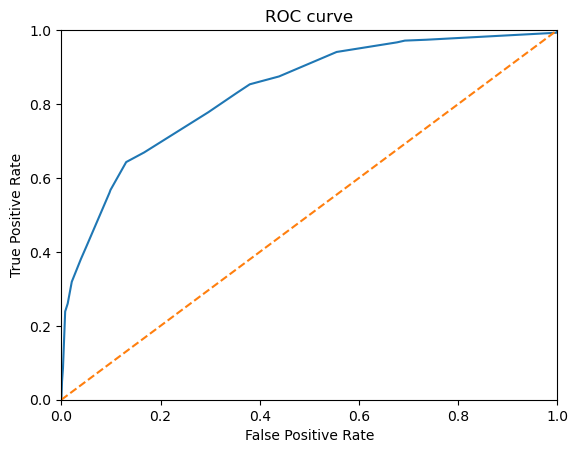

AUC-ROC score: 0.8337635723933434


In [155]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

# capturing curve of our trained model
fpr, tpr, thresholds = roc_curve(target_test, prob_test)

plt.figure()

# curve from model
plt.plot(fpr, tpr)
# curve for 'random model'
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# finding how much our model differs from the random model

auc_roc = roc_auc_score(target_test, prob_test)
print('AUC-ROC score:', auc_roc)

**Our model (blue line) is far exceeding the capabilites of a random classifier (orange dotted line), with an AUC-ROC value of (.834). The final model has a strong ability to distinguish between positive and negative classes.**

***Conclusion***

**Best Model: DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)**

**Best Threshold: 0.5700000000000003**

**Final Metric Scores: {'Accuracy': '0.822', 'Recall': '0.643', 'Precision': '0.569', 'F1': '0.604'}**

**Final Confusion Matrix: True Negative: 1371,  False Positive: 206, False Negative: 151, True Positive: 272**

**AUC-ROC Score: 0.8337635723933434**